# Title and Intro

In [1]:
# Imports
import pandas as pd
from geopy.distance import geodesic
import geopandas as gpd
from tqdm import tqdm
import numpy as np

## Step 1: Load Data

### MSA employment data
The dataset is from the Busines Dynamics Statistics (BDS) program at the U.S. Census Bureau. The data is available at the MSA level and is available for download at the [BDS website](fill_url). The data is available for download at the MSA leve. 

Dataset: `bds2020_msa_sec`, I droping all observations before 2000, data have the following variables:
- `year`: year
- `msa`: MSA code
- `sector`: 2-digit NAICS sector code.
- `emp`: Total employment in the sector in the MSA in the year.

All MSA's with at least one year of missing data are dropped from the dataset.

In [2]:
# %%
# Load MSA employemnt data
bds2020_msa_sec = pd.read_csv("/project/high_tech_ind/high_tech_job_flows/data/bds_all/bds2020_msa_sec.csv")
# Filter to keep only dates after 1990
# And only keep the columns we need ["year", "msa", "sector", "emp"]
bds2020_msa_sec = bds2020_msa_sec.loc[bds2020_msa_sec["year"] >= 2000, ["year", "msa", "sector", "emp"]]
# Determine for wich msa and sector we have no data
no_data = bds2020_msa_sec[bds2020_msa_sec.emp.apply(lambda x : not x.isdigit())]
list_msa_no_data = no_data["msa"].unique()
# Drop MSA with no data
bds2020_msa_sec = bds2020_msa_sec.loc[~bds2020_msa_sec["msa"].isin(list_msa_no_data)]
# Reset the index
bds2020_msa_sec = bds2020_msa_sec.reset_index(drop=True)

### MSA population data

Data is obtained from the ACS 5-year estimates. The data is available for download at the [Census website](https://www.census.gov/data/developers/data-sets/acs-5year.html). The data is available at the MSA level.

- I use this dataset to get a list of MSAs with population data above the median and filter `bds2020_msa_sec` to only include these MSAs.
-  I also drop Alaska, Hawaii, and Puerto Rico from the dataset.

The data goes from **98154** Year-MSA observations to **61047** Year-MSA observations.


In [3]:
msa_pop = pd.read_csv("/project/high_tech_ind/high_tech_job_flows/data/aux/msa_populations.csv")

In [4]:
# Read populaiton data
msa_pop = pd.read_csv("/project/high_tech_ind/high_tech_job_flows/data/aux/msa_populations.csv")
msa_pop = msa_pop[msa_pop.msa_name.str.contains("Metro")]
# Replace " Metro Area" with ""
msa_pop["msa_name"] = msa_pop["msa_name"].str.replace(" Metro Area", "")
# Split by comma and save as name and state
msa_pop["state"] = msa_pop["msa_name"].str.split(",").str[1]
msa_pop["name"] = msa_pop["msa_name"].str.split(",").str[0]
# Drop the msa_name column
msa_pop = msa_pop.drop(columns=["msa_name"])
# Drop bottom bottom quatile of population
msa_pop = msa_pop.loc[msa_pop["population"] > msa_pop["population"].quantile(0.5)]
# Drop if State is AK, HI, or PR
msa_pop = msa_pop.loc[~msa_pop["state"].isin([" AK", " HI", " PR"])]
# %%
# Filter bds2020_msa_sec to keep only msa in msa_pop
bds2020_msa_sec = bds2020_msa_sec.loc[bds2020_msa_sec["msa"].isin(msa_pop["msa_code"].unique())].reset_index(drop=True)

### Geographic data
I use the shapefiles from the [Census website](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html) to get the geographic information for each MSA. I use the shapefiles for the year 2019. The shapefiles are available at the MSA level. 
- Using the shapefiles, I calculate the latitude and longitude of the centroid of each MSA.
- This will be used to calculate the distance between MSAs.

In [66]:
# Load MSA geo data
msa_geo = gpd.read_file("/project/high_tech_ind/high_tech_job_flows/data/shape_files/tl_2019_us_cbsa/tl_2019_us_cbsa.shp", dtype={"CBSAFP": int})
# Aggregate county shapes to MSA shapes
msa_geo = msa_geo.dissolve(by="CBSAFP").reset_index()
# Compute the centroid coordinates for each MSA
msa_geo["centroid"] = msa_geo.centroid
# Extract the latitude and longitude coordinates from the centroid column
msa_geo["latitude"] = msa_geo["centroid"].y
msa_geo["longitude"] = msa_geo["centroid"].x
# Keep only the columns we need ["CBSAFP", "NAME", "latitude", "longitude"]
msa_geo = msa_geo[["CBSAFP", "NAME", "centroid", "latitude", "longitude"]]
# Rename the columns CBSAFP to msa
msa_geo = msa_geo.rename(columns={"CBSAFP": "msa", "NAME": "name"})
# Remove the MSA with no data
msa_geo.msa = msa_geo.msa.astype(int)
msa_geo = msa_geo.loc[~msa_geo["msa"].isin(list_msa_no_data)]
# Reset the index
msa_geo = msa_geo.reset_index(drop=True)
# Filter msa_geo to keep only msa in bds2020_msa_sec
msa_geo = msa_geo.loc[msa_geo["msa"].isin(bds2020_msa_sec["msa"].unique())].reset_index(drop=True)

/tmp/ipykernel_3502292/1469936281.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  msa_geo["centroid"] = msa_geo.centroid


### Worker mobility data

Data is from the [Longitudinal Employer-Household Dynamics (LEHD) program, Origin-Destination Employment Statistics (LODES)](https://lehd.ces.census.gov/data/#lodes). The data is available at the MSA level. The data is available for download at the [LEHD website](https://lehd.ces.census.gov/data/#lodes). I hace two samples of the data:
- `sex1_age_lower_07` Males age higher thatn 14 and lower than 54.
- `sex1_educ` All males age with and without college degree.

Both datasets have the following variables:
- `EE`: sEE	Job-to-Job Flows (Continuous Employment)
- `AQHire`: sAQHire	Job-to-Job Flows (Brief Nonemployment)
- `EES`: sEES	Stable Job-to-Job Flows (Continuous Employment)
- `AQHireS`: sAQHireS	Stable Job-to-Job Flows (Brief Nonemployment)
- `EESEarn_Orig`: sEESEarn_Orig	Average Earnings prior to Job-to-Job Flows (Continuous Employment)
- `EESEarn_Dest`: sEESEarn_Dest	Average Earnings following Job-to-Job Flows (Continuous Employment)
- `AQHireSEarn_Orig`: sAQHireSEarn_Orig	Average Earnings prior to Job-to-Job Flows (Brief Nonemployment)
- `AQHireSEarn_Dest`: sAQHireSEarn_Dest	Average Earnings following Job-to-Job Flows (Brief Nonemployment)

Additionally, `sex1_educ` has the following variable:
- `educ`: Education level of the worker:
  - `L`: No college degree.
  - `H`: College degree.


In [6]:
# Load worker mobility data
## sex1_age_lower_07
j2jod_sex1_age_lower_07 = pd.read_csv("/project/high_tech_ind/high_tech_job_flows/data/j2j_od/sex1_age_lower_07/proc_anual_no_own.csv")
# Rename geography_dest to msa_dest and geography_orig to msa_orig
j2jod_sex1_age_lower_07 = j2jod_sex1_age_lower_07.rename(columns={"geography_dest": "msa_dest", "geography_orig": "msa_orig"})

## sex1_educ
j2jod_sex1_educ = pd.read_csv("/project/high_tech_ind/high_tech_job_flows/data/j2j_od/sex1_educ/proc_anual_no_own.csv")
j2jod_sex1_educ = j2jod_sex1_educ.rename(columns={"geography_dest": "msa_dest", "geography_orig": "msa_orig"})

# Calculate total migration for each msa EE + AQHire 
j2jod_sex1_educ["OFLOW"] = j2jod_sex1_educ["EE"] + j2jod_sex1_educ["AQHire"]
j2jod_sex1_age_lower_07["OFLOW"] = j2jod_sex1_age_lower_07["EE"] + j2jod_sex1_age_lower_07["AQHire"]


In [7]:
# Drop msa-year pairs with no migration i.e (OFLOW == 0)
# j2jod_sex1_educ = j2jod_sex1_educ.loc[j2jod_sex1_educ["OFLOW"] > 0]
# j2jod_sex1_age_lower_07 = j2jod_sex1_age_lower_07.loc[j2jod_sex1_age_lower_07["OFLOW"] > 0]

## Step 2: The elements gravity model

The gravity equation of migration is a theoretical framework that explains the migration flows between two locations based on origin and destination characteristics and measures of distance between them.

$$s^t_{ij} = \beta_1 d_{ij} + \beta_2 h_{ij} + FE_j + FE_i + FE_t$$

Here $s^t_{ij}$ is the share of migration of MSA $i$ to MSA $j$, $FE_j$ is a fixed effect for MSA $j$, $FE_i$ is a fixed effect for MSA $i$, and $FE_t$ is a fixed effect for year $t$.

I use two measures of distance between MSAs:
- $d_{ij}$: The geographic distance between the centroids of MSAs $i$ and $j$.
- $h_{ij}$: Is an index of sectoral dissimilarity between MSAs $i$ and $j$. It is calculated as the sum of the absolute differences in the employment shares of each sector between MSAs $i$ and $j$. $$h_{ij} = \sum_{s=1}^{S} \left| \frac{e_{is}}{e_{i}} - \frac{e_{js}}{e_{j}} \right|$$ where $e_{is}$ is the employment in sector $s$ in MSA $i$ and $e_{i}$ is the total employment in MSA $i$.

### Compute the distance between each MSA

Next I calculate the distances between different Metropolitan Statistical Areas (MSAs) based on their geographic coordinates (latitude and longitude), by looping through all possible pairs of MSAs, calculating the distance between each pair, and saving the results in a table. The table has three columns: "msa_orig" (the origin MSA), "msa_dest" (the destination MSA), and "distance" (the distance between them). The progress of the calculation is shown using a progress bar.

In [8]:
# Compute the distance between each MSA
msa_dist = {
    "msa_orig": [],
    "msa_dest": [],
    "distance": []
}

num_iterations = len(msa_geo) * len(msa_geo)
progress_bar = tqdm(total=num_iterations)
for i in range(len(msa_geo)):
    msa_orig = msa_geo["msa"][i]
    for j in range(len(msa_geo)):
        msa_dest = msa_geo["msa"][j]
        if msa_orig == msa_dest:
            continue
        msa_dist["msa_orig"].append(msa_orig)
        msa_dist["msa_dest"].append(msa_dest)
        msa_dist["distance"].append(geodesic((msa_geo["latitude"][i], msa_geo["longitude"][i]), (msa_geo["latitude"][j], msa_geo["longitude"][j])).miles)
        progress_bar.update(1)


progress_bar.close()
msa_dist = pd.DataFrame(msa_dist)


 99%|█████████▉| 22952/23104 [00:04<00:00, 5417.23it/s]


### Compute the sectoral dissimilarity between each MSA

This code calculates the sectoral dissimilarity between different Metropolitan Statistical Areas (MSAs). It does this by iterating over all possible pairs of MSAs and comparing the share of employment in each sector for each pair. The dissimilarity is calculated as the absolute difference between the shares of employment in each sector and then summed across all sectors. The results are saved in a table with four columns: "year" (the year of the data), "msa_orig" (the origin MSA), "msa_dest" (the destination MSA), and "dissimilarity" (the dissimilarity between the MSAs). The progress of the calculation is shown using a progress bar. Finally, the table is converted to a Pandas DataFrame and the "msa_orig" and "msa_dest" columns are converted to integers.

In [9]:
# Sectoral dissimilarity between each MSA
bds2020_msa_sec.emp = bds2020_msa_sec.emp.astype(int)
# Compute the share of employment in each sector for each MSA
# Calculate the total employment for each year-msa group
bds2020_msa_sec["total_emp"] = bds2020_msa_sec.groupby(['year', 'msa'])['emp'].transform('sum')
# Calculate the share of each sector's employment within each year-msa group
bds2020_msa_sec['share_emp'] = bds2020_msa_sec['emp'] / bds2020_msa_sec["total_emp"]
bds2020_msa_sec_shares = pd.pivot_table(bds2020_msa_sec, values='share_emp', index=['year', 'msa'], columns='sector').reset_index()

# iterate over years 
years = bds2020_msa_sec_shares.year.unique()
msas = bds2020_msa_sec_shares.msa.unique()
msa_sector_dsim = {
    "year": [],
    "msa_orig": [],
    "msa_dest": [],
    "dissimilarity": []
}

for year in years:
    # Iterate over MSA
    print(year)
    sub_bds2020_msa_sec = bds2020_msa_sec_shares.loc[bds2020_msa_sec_shares["year"] == year].reset_index(drop=True)
    num_iterations = len(sub_bds2020_msa_sec) * len(sub_bds2020_msa_sec)
    progress_bar = tqdm(total=num_iterations)
    for i in range(len(sub_bds2020_msa_sec)):
        msa_orig_shares = bds2020_msa_sec_shares.iloc[i]
        # Get the MSA code
        msa_orig = msa_orig_shares["msa"]
        # Remvoe the year and msa columns
        msa_orig_shares = msa_orig_shares.drop(["year", "msa"]).copy()
        # convert to numpy array
        msa_orig_shares = msa_orig_shares.to_numpy()
        for j in range(len(sub_bds2020_msa_sec)):
            msa_dest_shares = bds2020_msa_sec_shares.iloc[j].copy()
            # Get the MSA code
            
            msa_dest = msa_dest_shares["msa"]
            if msa_orig == msa_dest:
                continue
            # Compute the dissimilarity between the two MSA
            msa_dest_shares = msa_dest_shares.drop(["year", "msa"])
            # convert to numpy array
            msa_dest_shares = msa_dest_shares.to_numpy()
            dis = np.abs(msa_dest_shares - msa_orig_shares).sum()
            # Add all the information to the dictionary
            msa_sector_dsim["year"].append(year)
            msa_sector_dsim["msa_orig"].append(msa_orig)
            msa_sector_dsim["msa_dest"].append(msa_dest)
            msa_sector_dsim["dissimilarity"].append(dis)
            progress_bar.update(1)

    progress_bar.close()

msa_sector_dsim = pd.DataFrame(msa_sector_dsim)
msa_sector_dsim.msa_orig = msa_sector_dsim.msa_orig.astype(int)
msa_sector_dsim.msa_dest = msa_sector_dsim.msa_dest.astype(int)

2000


 99%|█████████▉| 23256/23409 [00:08<00:00, 2658.86it/s]


2001


 99%|█████████▉| 23256/23409 [00:08<00:00, 2657.59it/s]


2002


 99%|█████████▉| 23256/23409 [00:08<00:00, 2655.88it/s]


2003


 99%|█████████▉| 23256/23409 [00:08<00:00, 2652.32it/s]


2004


 99%|█████████▉| 23256/23409 [00:08<00:00, 2653.51it/s]


2005


 99%|█████████▉| 23256/23409 [00:08<00:00, 2661.81it/s]


2006


 99%|█████████▉| 23256/23409 [00:08<00:00, 2661.32it/s]


2007


 99%|█████████▉| 23256/23409 [00:08<00:00, 2664.49it/s]


2008


 99%|█████████▉| 23256/23409 [00:08<00:00, 2661.09it/s]


2009


 99%|█████████▉| 23256/23409 [00:08<00:00, 2667.36it/s]


2010


 99%|█████████▉| 23256/23409 [00:08<00:00, 2663.87it/s]


2011


 99%|█████████▉| 23256/23409 [00:08<00:00, 2682.89it/s]


2012


 99%|█████████▉| 23256/23409 [00:08<00:00, 2657.76it/s]


2013


 99%|█████████▉| 23256/23409 [00:08<00:00, 2669.53it/s]


2014


 99%|█████████▉| 23256/23409 [00:08<00:00, 2661.73it/s]


2015


 99%|█████████▉| 23256/23409 [00:08<00:00, 2663.52it/s]


2016


 99%|█████████▉| 23256/23409 [00:08<00:00, 2674.92it/s]


2017


 99%|█████████▉| 23256/23409 [00:08<00:00, 2667.90it/s]


2018


 99%|█████████▉| 23256/23409 [00:08<00:00, 2659.22it/s]


2019


 99%|█████████▉| 23256/23409 [00:08<00:00, 2656.11it/s]


2020


 99%|█████████▉| 23256/23409 [00:08<00:00, 2646.33it/s]


### Compute the shares of migration between each MSA and Earninngs differential

In [10]:
def migration_shares(j2jod, group_vars = []):
    # Variables to group by
    group_vars += ['year', 'msa_orig']
    # Calculate the total outflow for each year-msa group
    j2jod["OFLOW_total"] = j2jod.groupby(group_vars)["OFLOW"].transform('sum')
    # Calculate the share of outflow for each year-msa group
    j2jod["OFLOW_share"] = j2jod["OFLOW"] / j2jod["OFLOW_total"]
    # Calculate total income before and after migration
    j2jod["EESEarn_Orig_total"] = j2jod["EE"] * j2jod["EESEarn_Orig"]
    j2jod["EESEarn_Dest_total"] = j2jod["EE"] * j2jod["EESEarn_Dest"]
    j2jod["AQHireSEarn_Orig_total"] = j2jod["AQHire"] * j2jod["AQHireSEarn_Orig"]
    j2jod["AQHireSEarn_Dest_total"] = j2jod["AQHire"] * j2jod["AQHireSEarn_Dest"]
    # Calculate avg income before and after migration as sum of EE and AQHire
    j2jod["AVG_INC_ORIG"]  = (j2jod["EESEarn_Orig_total"] + j2jod["AQHireSEarn_Orig_total"]) / j2jod["OFLOW"]
    j2jod["AVGL_INC_DEST"] = (j2jod["EESEarn_Dest_total"] + j2jod["AQHireSEarn_Dest_total"]) / j2jod["OFLOW"]
    # Calculate averga earnings difference between the two MSAs
    j2jod["EARN_DIFF"] = j2jod["AVGL_INC_DEST"] - j2jod["AVG_INC_ORIG"]
    return j2jod

## Step 3: Merge the data

Next I merge the data from the different datasets. I aim to add sectora dissimilarity and distance between MSAs to the worker mobility data. 

In [11]:
# Merge the MSA distance and the MSA sector dissimilarity
msa_dist_sector_dsim = msa_sector_dsim.merge(msa_dist, on=["msa_orig", "msa_dest"], how="left")

# Merge msa_dist_sector_dsim and j2jod
msa_dist_sector_dsimj2jod_sex1_age_lower_07 = msa_dist_sector_dsim.merge(
    j2jod_sex1_age_lower_07[[ "year", "msa_orig", "msa_dest", "EE", "AQHire", "OFLOW", 
                                "EESEarn_Dest", "EESEarn_Orig", "AQHireSEarn_Dest", "AQHireSEarn_Orig"]],
                                                        on=["year", "msa_orig", "msa_dest"], how="inner")
# Add names to the MSAs 
msa_pop.rename(columns={"msa_code": "msa"}, inplace=True)
msa_dist_sector_dsimj2jod_sex1_age_lower_07 = msa_dist_sector_dsimj2jod_sex1_age_lower_07.merge(msa_pop[["msa", "name"]], left_on="msa_orig", right_on="msa", how="left")
# Drop the msa column
msa_dist_sector_dsimj2jod_sex1_age_lower_07.drop(columns=["msa"], inplace=True)
msa_dist_sector_dsimj2jod_sex1_age_lower_07 = msa_dist_sector_dsimj2jod_sex1_age_lower_07.rename(columns={"name": "msa_orig_name"})
msa_dist_sector_dsimj2jod_sex1_age_lower_07 = msa_dist_sector_dsimj2jod_sex1_age_lower_07.merge(msa_pop[["msa", "name"]], left_on="msa_dest", right_on="msa", how="left")
# Drop the msa column
msa_dist_sector_dsimj2jod_sex1_age_lower_07.drop(columns=["msa"], inplace=True)
msa_dist_sector_dsimj2jod_sex1_age_lower_07 = msa_dist_sector_dsimj2jod_sex1_age_lower_07.rename(columns={"name": "msa_dest_name"})

# Calculate migration shares
msa_dist_sector_dsimj2jod_sex1_age_lower_07 = migration_shares(msa_dist_sector_dsimj2jod_sex1_age_lower_07)

# Drop NaN from OFLOW_share
msa_dist_sector_dsimj2jod_sex1_age_lower_07 = msa_dist_sector_dsimj2jod_sex1_age_lower_07[msa_dist_sector_dsimj2jod_sex1_age_lower_07.OFLOW_share == msa_dist_sector_dsimj2jod_sex1_age_lower_07.OFLOW_share]

In [12]:
# Merge msa_dist_sector_dsim and j2jod
msa_dist_sector_dsimj2jod_sex1_educ = msa_dist_sector_dsim.merge(
    j2jod_sex1_educ[[ "year", "msa_orig", "msa_dest",  "education", "EE", "AQHire", "OFLOW",
                                "EESEarn_Dest", "EESEarn_Orig", "AQHireSEarn_Dest", "AQHireSEarn_Orig"]],
                                                        on=["year", "msa_orig", "msa_dest"], how="inner")
# Add names to the MSAs 
msa_dist_sector_dsimj2jod_sex1_educ = msa_dist_sector_dsimj2jod_sex1_educ.merge(msa_pop[["msa", "name"]], left_on="msa_orig", right_on="msa", how="left")
# Drop the msa column
msa_dist_sector_dsimj2jod_sex1_educ.drop(columns=["msa"], inplace=True)
msa_dist_sector_dsimj2jod_sex1_educ = msa_dist_sector_dsimj2jod_sex1_educ.rename(columns={"name": "msa_orig_name"})
msa_dist_sector_dsimj2jod_sex1_educ = msa_dist_sector_dsimj2jod_sex1_educ.merge(msa_pop[["msa", "name"]], left_on="msa_dest", right_on="msa", how="left")
# Drop the msa column
msa_dist_sector_dsimj2jod_sex1_educ.drop(columns=["msa"], inplace=True)
msa_dist_sector_dsimj2jod_sex1_educ = msa_dist_sector_dsimj2jod_sex1_educ.rename(columns={"name": "msa_dest_name"})

# Calculate migration shares
msa_dist_sector_dsimj2jod_sex1_educ = migration_shares(msa_dist_sector_dsimj2jod_sex1_educ, group_vars = ["education"])

# Drop NaN from OFLOW_share
msa_dist_sector_dsimj2jod_sex1_educ = msa_dist_sector_dsimj2jod_sex1_educ[msa_dist_sector_dsimj2jod_sex1_educ.OFLOW_share == msa_dist_sector_dsimj2jod_sex1_educ.OFLOW_share]

## Step 4: Normalizations and transformations

I perform the following normalizations and transformations to the data:
- I normalize the following:
  - `distance`
  - `dissimilarity`
  - `share_EE`
  - `share_AQHire`
  by subtracting the mean and dividing by the standard deviation.

In [13]:
# select columns to normalize
cols_to_norm = ['distance', 'dissimilarity']

# Compute z-scores
msa_dist_sector_dsimj2jod_sex1_age_lower_07[cols_to_norm] = msa_dist_sector_dsimj2jod_sex1_age_lower_07[cols_to_norm].apply(lambda x: (x - x.mean()) / x.std())
msa_dist_sector_dsimj2jod_sex1_educ[cols_to_norm] = msa_dist_sector_dsimj2jod_sex1_educ[cols_to_norm].apply(lambda x: (x - x.mean()) / x.std())

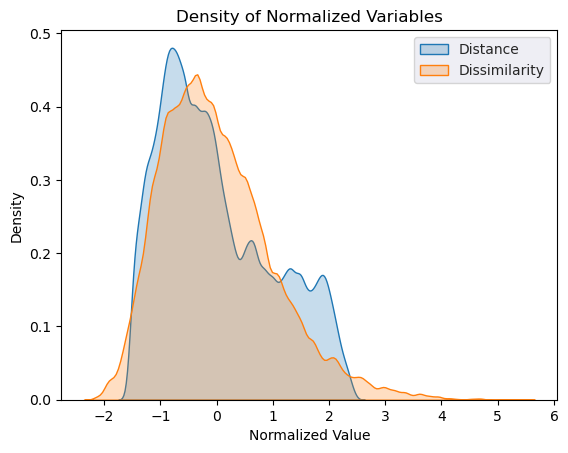

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'
# Normalize the variables by subtracting the mean and dividing by the standard deviation

# Plot the density of the normalized variables using Seaborn
sns.kdeplot(data=msa_dist_sector_dsimj2jod_sex1_educ, x="distance", fill=True, label="Distance")
sns.kdeplot(data=msa_dist_sector_dsimj2jod_sex1_educ, x="dissimilarity", fill=True, label="Dissimilarity")
# sns.kdeplot(data=msa_dist_sector_dsimj2jod_sex1_educ, x="share_EE", shade=True, label="Share EE")
# sns.kdeplot(data=msa_dist_sector_dsimj2jod_sex1_educ, x="share_AQHire", shade=True, label="Share AQ Hire")
sns.set_style("dark")
# Add a title and labels for the x and y axis
plt.title("Density of Normalized Variables")
plt.xlabel("Normalized Value")
plt.ylabel("Density")
plt.legend()
plt.show()

In [72]:
# Job Creation and Job Destruction
# Get national data
data_bds_nat = pd.read_csv("/project/high_tech_ind/high_tech_job_flows/data/bds_all/bds2020.csv")
data_bds_nat = data_bds_nat[data_bds_nat["year"] >= 2000]
# Get MSA level data
data_bds_msa = pd.read_csv("/project/high_tech_ind/high_tech_job_flows/data/bds_all/bds2020_msa.csv")
data_bds_msa = data_bds_msa[data_bds_msa["year"] >= 2000]
# Get average employment for each MSA over the sample
data_bds_msa_avg = data_bds_msa.groupby(["msa"])["emp"].mean().reset_index()
data_bds_msa_avg = data_bds_msa_avg.rename(columns={"emp": "emp_mean"})
# Read HT data at the national level
data_bds_ht_nat = pd.read_csv("/project/high_tech_ind/high_tech_job_flows/data/bds_high_tech/interim/nationwide.csv")
data_bds_ht_nat = data_bds_ht_nat[data_bds_ht_nat["year"] >= 2000]
# Read HT data at the MSA level
data_bds_ht_msa = pd.read_csv("/project/high_tech_ind/high_tech_job_flows/data/bds_high_tech/interim/msac.csv")
data_bds_ht_msa = data_bds_ht_msa[data_bds_ht_msa["year"] >= 2000]
# Rename geography to msa
data_bds_ht_msa = data_bds_ht_msa.rename(columns={"geography": "msa"})
# Get percentage of high tech jobs in each MSA
data_bds_ht_msa.loc[:, "share_ht"] = data_bds_ht_msa["emp_ht"] /( data_bds_ht_msa["emp_ht"] + data_bds_ht_msa["emp_nht"])

# Get MSA's in the top 25% of employment
data_bds_nat_avg_emp = data_bds_msa.groupby(["msa"])["emp"].sum().rank(pct=True).reset_index().rename(columns={"emp": "emp_rank"})
msa_list = data_bds_nat_avg_emp[data_bds_nat_avg_emp.emp_rank > 0.75].msa.unique().tolist()

# Filter data to only include MSA's in the top 25% of employment
data_bds_ht_msa = data_bds_ht_msa[data_bds_ht_msa.msa.isin(msa_list)]

# Calculate the share of total employment in each MSA for each year firms, estabs, job_creation_ht, job_creation_births_ht', 'job_creation_continuers_ht', 'job_destruction_ht', 'job_destruction_deaths_ht', 'job_destruction_continuers_ht', 'net_job_creation_ht'
cols_to_share = ['emp_ht', 'firms_ht', 'estabs_ht', 'job_creation_ht', 'job_creation_births_ht', 'job_creation_continuers_ht', 'job_destruction_ht', 'job_destruction_deaths_ht', 'job_destruction_continuers_ht', 'net_job_creation_ht']
for c in cols_to_share:
    data_bds_ht_msa[c + "_share_total"] = data_bds_ht_msa[c] / data_bds_ht_msa.groupby(["year"])[c].transform(sum)



# group dataframe by year and calculate percentile rank within each year group
data_bds_ht_msa['share_ht_rank_variate'] = data_bds_ht_msa.groupby('year')['share_ht'].rank(pct=True)


In [16]:
### Alternative measure of what is high tech msa
# Add names
data_bds_ht_msa_ = pd.merge(data_bds_ht_msa, msa_pop.rename( columns = {"msa_code":"msa"}), on="msa", how="inner")
sub_data_bds_ht_msa = data_bds_ht_msa_[data_bds_ht_msa_.year == 2016]
# Job Creation
sub_data_bds_ht_msa["job_creation_rank"] = sub_data_bds_ht_msa["job_creation_ht"].rank(pct=True)

sub_data_bds_ht_msa.sort_values(
    by="share_ht", ascending=False)[
        ["name", "emp_ht", "job_creation_ht", "job_creation_rate_ht", "job_creation_rank"]
        ].head(20)

/tmp/ipykernel_3502292/2662035325.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data_bds_ht_msa["job_creation_rank"] = sub_data_bds_ht_msa["job_creation_ht"].rank(pct=True)


name    emp_ht  job_creation_ht  \
3004   San Jose-Sunnyvale-Santa Clara  260436.0          42269.0   
1496                       Huntsville   38884.0           4366.0   
413                           Boulder   24499.0           3018.0   
3525  Washington-Arlington-Alexandria  364135.0          60424.0   
2437    Palm Bay-Melbourne-Titusville   24501.0           5035.0   
2983    San Francisco-Oakland-Fremont  268391.0          47632.0   
975                Durham-Chapel Hill   31120.0           4481.0   
3546                          Wichita   31101.0           1485.0   
226      Austin-Round Rock-San Marcos   95271.0          17168.0   
3130          Seattle-Tacoma-Bellevue  169394.0          23475.0   
1934                Manchester-Nashua   21427.0           2412.0   
392           Boston-Cambridge-Quincy  237480.0          30516.0   
2668                     Raleigh-Cary   47963.0           7737.0   
2962    San Diego-Carlsbad-San Marcos  123835.0          20582.0   
121                         Ann Arbor   13959.0           1964.0   
1913                          Madison   28717.0           4140.0   
3382                    Trenton-Ewing   17784.0           2582.0   
538                      Cedar Rapids   11767.0            625.0   
58                        Albuquerque   27561.0           3101.0   
434       Bridgeport-Stamford-Norwalk   38312.0           3043.0   

      job_creation_rate_ht  job_creation_rank  
3004                16.717           0.982857  
1496                11.344           0.811429  
413                 11.132           0.737143  
3525                16.575           1.000000  
2437                21.161           0.840000  
2983                18.399           0.988571  
975                 15.050           0.817143  
3546                 4.402           0.588571  
226                 18.763           0.937143  
3130                14.254           0.954286  
1934                11.558           0.685714  
392                 12.917           0.977143  
2668                16.779           0.880000  
2962                17.068           0.948571  
121                 14.456           0.651429  
1913                14.816           0.805714  
3382                14.828           0.702857  
538                  5.379           0.400000  
58                  11.556           0.748571  
434                  7.953           0.742857

In [17]:
# Compute the average share of high tech for each MSA
# Get the percentile rank of element
share_ht_msa = data_bds_ht_msa.groupby("msa")["share_ht"].mean().rank(pct=True).reset_index().rename(columns={"share_ht": "share_ht_rank"})

# Merge with flow data to add share_ht and ranks to each flow
# share_ht
msa_dist_sector_dsimj2jod_sex1_age_lower_07 = pd.merge(msa_dist_sector_dsimj2jod_sex1_age_lower_07, data_bds_ht_msa[["year", "msa", "share_ht"]], left_on=["year", "msa_orig"], right_on=["year",  "msa"], how="inner")
msa_dist_sector_dsimj2jod_sex1_age_lower_07 = msa_dist_sector_dsimj2jod_sex1_age_lower_07.rename(columns={"share_ht": "share_ht_orig"})
msa_dist_sector_dsimj2jod_sex1_age_lower_07 = msa_dist_sector_dsimj2jod_sex1_age_lower_07.drop(columns=["msa"])
msa_dist_sector_dsimj2jod_sex1_age_lower_07 = pd.merge(msa_dist_sector_dsimj2jod_sex1_age_lower_07, data_bds_ht_msa[["year", "msa", "share_ht"]], left_on=["year", "msa_dest"], right_on=["year",  "msa"], how="inner")
msa_dist_sector_dsimj2jod_sex1_age_lower_07 = msa_dist_sector_dsimj2jod_sex1_age_lower_07.rename(columns={"share_ht": "share_ht_dest"})
msa_dist_sector_dsimj2jod_sex1_age_lower_07 = msa_dist_sector_dsimj2jod_sex1_age_lower_07.drop(columns=["msa"])
# # share_ht_rank
msa_dist_sector_dsimj2jod_sex1_age_lower_07 = pd.merge(msa_dist_sector_dsimj2jod_sex1_age_lower_07, share_ht_msa[["msa", "share_ht_rank"]], left_on="msa_orig", right_on="msa", how="inner")
msa_dist_sector_dsimj2jod_sex1_age_lower_07 = msa_dist_sector_dsimj2jod_sex1_age_lower_07.rename(columns={"share_ht_rank": "share_ht_rank_orig"})
msa_dist_sector_dsimj2jod_sex1_age_lower_07 = msa_dist_sector_dsimj2jod_sex1_age_lower_07.drop(columns=["msa"])
msa_dist_sector_dsimj2jod_sex1_age_lower_07 = pd.merge(msa_dist_sector_dsimj2jod_sex1_age_lower_07, share_ht_msa[["msa", "share_ht_rank"]], left_on="msa_dest", right_on="msa", how="inner")
msa_dist_sector_dsimj2jod_sex1_age_lower_07 = msa_dist_sector_dsimj2jod_sex1_age_lower_07.rename(columns={"share_ht_rank": "share_ht_rank_dest"})
msa_dist_sector_dsimj2jod_sex1_age_lower_07 = msa_dist_sector_dsimj2jod_sex1_age_lower_07.drop(columns=["msa"])
# share_ht_rank_variate
msa_dist_sector_dsimj2jod_sex1_age_lower_07 = pd.merge(msa_dist_sector_dsimj2jod_sex1_age_lower_07, data_bds_ht_msa[["msa", "year", "share_ht_rank_variate"]], left_on=["year", "msa_orig"], right_on=["year", "msa"], how="inner")
msa_dist_sector_dsimj2jod_sex1_age_lower_07 = msa_dist_sector_dsimj2jod_sex1_age_lower_07.rename(columns={"share_ht_rank_variate": "share_ht_orig_variate"})
msa_dist_sector_dsimj2jod_sex1_age_lower_07 = msa_dist_sector_dsimj2jod_sex1_age_lower_07.drop(columns=["msa"])
msa_dist_sector_dsimj2jod_sex1_age_lower_07 = pd.merge(msa_dist_sector_dsimj2jod_sex1_age_lower_07, data_bds_ht_msa[["msa", "year", "share_ht_rank_variate"]], left_on=["year", "msa_dest"], right_on=["year", "msa"], how="inner")
msa_dist_sector_dsimj2jod_sex1_age_lower_07 = msa_dist_sector_dsimj2jod_sex1_age_lower_07.rename(columns={"share_ht_rank_variate": "share_ht_dest_variate"})
msa_dist_sector_dsimj2jod_sex1_age_lower_07 = msa_dist_sector_dsimj2jod_sex1_age_lower_07.drop(columns=["msa"])

# # Data with education
# # share_ht
msa_dist_sector_dsimj2jod_sex1_educ = pd.merge(msa_dist_sector_dsimj2jod_sex1_educ, data_bds_ht_msa[["year", "msa", "share_ht"]], left_on=["year", "msa_orig"], right_on=["year",  "msa"], how="inner")
msa_dist_sector_dsimj2jod_sex1_educ = msa_dist_sector_dsimj2jod_sex1_educ.rename(columns={"share_ht": "share_ht_orig"})
msa_dist_sector_dsimj2jod_sex1_educ = msa_dist_sector_dsimj2jod_sex1_educ.drop(columns=["msa"])
msa_dist_sector_dsimj2jod_sex1_educ = pd.merge(msa_dist_sector_dsimj2jod_sex1_educ, data_bds_ht_msa[["year", "msa", "share_ht"]], left_on=["year", "msa_dest"], right_on=["year",  "msa"], how="inner")
msa_dist_sector_dsimj2jod_sex1_educ = msa_dist_sector_dsimj2jod_sex1_educ.rename(columns={"share_ht": "share_ht_dest"})
msa_dist_sector_dsimj2jod_sex1_educ = msa_dist_sector_dsimj2jod_sex1_educ.drop(columns=["msa"])
# share_ht_rank
msa_dist_sector_dsimj2jod_sex1_educ = pd.merge(msa_dist_sector_dsimj2jod_sex1_educ, share_ht_msa[["msa", "share_ht_rank"]], left_on="msa_orig", right_on="msa", how="inner")
msa_dist_sector_dsimj2jod_sex1_educ = msa_dist_sector_dsimj2jod_sex1_educ.rename(columns={"share_ht_rank": "share_ht_rank_orig"})
msa_dist_sector_dsimj2jod_sex1_educ = msa_dist_sector_dsimj2jod_sex1_educ.drop(columns=["msa"])
msa_dist_sector_dsimj2jod_sex1_educ = pd.merge(msa_dist_sector_dsimj2jod_sex1_educ, share_ht_msa[["msa", "share_ht_rank"]], left_on="msa_dest", right_on="msa", how="inner")
msa_dist_sector_dsimj2jod_sex1_educ = msa_dist_sector_dsimj2jod_sex1_educ.rename(columns={"share_ht_rank": "share_ht_rank_dest"})
msa_dist_sector_dsimj2jod_sex1_educ = msa_dist_sector_dsimj2jod_sex1_educ.drop(columns=["msa"])
# share_ht_rank_variate
msa_dist_sector_dsimj2jod_sex1_educ = pd.merge(msa_dist_sector_dsimj2jod_sex1_educ, data_bds_ht_msa[["msa", "year", "share_ht_rank_variate"]], left_on=["year", "msa_orig"], right_on=["year", "msa"], how="inner")
msa_dist_sector_dsimj2jod_sex1_educ = msa_dist_sector_dsimj2jod_sex1_educ.rename(columns={"share_ht_rank_variate": "share_ht_orig_variate"})
msa_dist_sector_dsimj2jod_sex1_educ = msa_dist_sector_dsimj2jod_sex1_educ.drop(columns=["msa"])
msa_dist_sector_dsimj2jod_sex1_educ = pd.merge(msa_dist_sector_dsimj2jod_sex1_educ, data_bds_ht_msa[["msa", "year", "share_ht_rank_variate"]], left_on=["year", "msa_dest"], right_on=["year", "msa"], how="inner")
msa_dist_sector_dsimj2jod_sex1_educ = msa_dist_sector_dsimj2jod_sex1_educ.rename(columns={"share_ht_rank_variate": "share_ht_dest_variate"})
msa_dist_sector_dsimj2jod_sex1_educ = msa_dist_sector_dsimj2jod_sex1_educ.drop(columns=["msa"])

In [18]:
# load unemployment rate data
unemp = pd.read_csv("/project/high_tech_ind/high_tech_job_flows/data/BLS/proc/bls_msa_unemployment_rate_yearly.csv")
# rename columns
unemp = unemp.rename(columns={"geography": "msa"})
# add unemployment rate to data
data_bds_ht_msa = data_bds_ht_msa.merge(unemp, on=["msa", "year"], how="inner")

In [19]:
data_bds_ht_msa.to_csv("/project/high_tech_ind/high_tech_job_flows/data/bds_high_tech/proc/data_bds_ht_msa.csv", index=False)

In [20]:
# Save the data
msa_dist_sector_dsimj2jod_sex1_age_lower_07.to_csv("/project/high_tech_ind/high_tech_job_flows/data/j2j_od/proc/msa_dist_sector_dsimj2jod_sex1_age_lower_07.csv", index=False)
msa_dist_sector_dsimj2jod_sex1_educ.to_csv("/project/high_tech_ind/high_tech_job_flows/data/j2j_od/proc/msa_dist_sector_dsimj2jod_sex1_educ.csv", index=False)

In [35]:
#Load the data
msa_dist_sector_dsimj2jod_sex1_age_lower_07 = pd.read_csv("/project/high_tech_ind/high_tech_job_flows/data/j2j_od/proc/msa_dist_sector_dsimj2jod_sex1_age_lower_07.csv")
msa_dist_sector_dsimj2jod_sex1_educ = pd.read_csv("/project/high_tech_ind/high_tech_job_flows/data/j2j_od/proc/msa_dist_sector_dsimj2jod_sex1_educ.csv")

# Maps

In [229]:
data_qwi = pd.read_csv("/project/high_tech_ind/high_tech_job_flows/data/qwi/qwi_msa_educ.csv")
data_qwi.dropna(inplace=True)
data_qwi["year"] = data_qwi["time"].apply(lambda x : x.split("-")[0]).astype(int)
data_qwi = data_qwi[~data_qwi.education.isin(["E0", "E5"])]
data_qwi.loc[data_qwi.education != "E4", "education"] = "L"
data_qwi.loc[data_qwi.education == "E4", "education"] = "H"
data_qwi = data_qwi.groupby(["year", "msa", "education"]).Emp.sum().reset_index().pivot_table(index=["year", "msa"], columns="education", values="Emp").reset_index()
data_qwi["H_pct"] = data_qwi["H"] / (data_qwi["H"] + data_qwi["L"])
data_qwi_avg = data_qwi.groupby("msa").H_pct.mean().reset_index()
data_qwi_avg.sort_values("H_pct", ascending=False, inplace=True)

## Save the data
data_qwi_avg.to_csv("/project/high_tech_ind/high_tech_job_flows/data/qwi/proc/data_qwi_avg.csv", index=False)
data_qwi.to_csv("/project/high_tech_ind/high_tech_job_flows/data/qwi/proc/data_qwi.csv", index=False)

In [231]:
# Drop msa not present in the whole sample
msa_list = data_qwi.msa.unique()
for y in data_qwi.year.unique():
    msa_list = np.intersect1d(msa_list, data_qwi[data_qwi.year == y].msa.unique())


data_qwi = data_qwi[data_qwi.msa.isin(msa_list)]

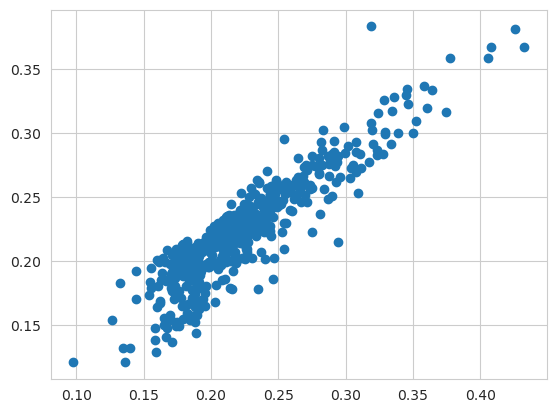

In [232]:
plt.scatter(data_qwi[data_qwi.year == 2001].H_pct, data_qwi[data_qwi.year == 2019].H_pct)

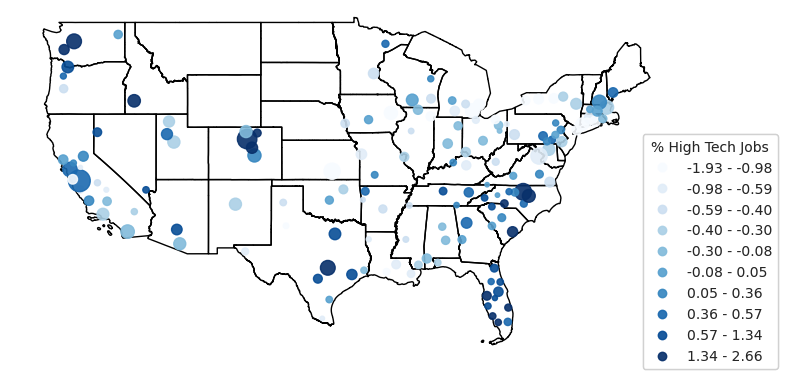

In [202]:
year_avg = msa_dist_sector_dsimj2jod_sex1_educ.groupby(["msa_orig", "education"]).OFLOW.sum().reset_index().rename(columns={"msa_orig": "msa"}).merge(
    msa_dist_sector_dsimj2jod_sex1_educ.groupby(["msa_dest", "education"]).OFLOW.sum().reset_index().rename(columns={"msa_dest": "msa", "OFLOW" : "IFLOW"}),
                on=["msa", "education"], how="inner")                                           

data_heduc = msa_geo.merge(year_avg[year_avg.education == "H"], on="msa", how="inner").merge(data_bds_ht_msa.groupby("msa").share_ht.mean().reset_index(), on = "msa")

data_heduc = data_heduc.merge(data_bds_msa.groupby("msa").emp.mean().reset_index(), on = "msa")

data_heduc = data_heduc.merge(data_qwi_avg, on = "msa")

# Load shapefile data from web URL
url = 'https://www2.census.gov/geo/tiger/TIGER2019/STATE/tl_2019_us_state.zip'
us_states = gpd.read_file(url)

# Filter to only show continental US states
continental_states = [  'Washington', 'Oregon', 'California', 'Nevada', 'Idaho', 'Montana', 'Wyoming', 'Utah',
                        'Arizona', 'New Mexico', 'Colorado', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas',
                        'Oklahoma', 'Texas', 'Minnesota', 'Iowa', 'Missouri', 'Arkansas', 'Louisiana', 'Wisconsin',
                        'Illinois', 'Michigan', 'Indiana', 'Ohio', 'Kentucky', 'Tennessee', 'Mississippi', 'Alabama',
                        'Georgia', 'Florida', 'South Carolina', 'North Carolina', 'Virginia', 'West Virginia',
                        'Maryland', 'Delaware', 'New Jersey', 'Pennsylvania', 'New York', 'Connecticut', 'Rhode Island',
                        'Massachusetts', 'Vermont', 'New Hampshire', 'Maine']

continental_us_states = us_states[us_states['NAME'].isin(continental_states)]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-130, -65])
ax.set_ylim([23, 50])
ax.axis('off')



data_heduc["net_flow"] = (data_heduc["IFLOW"] - data_heduc["OFLOW"])
data_heduc["IFLOW_pct"] = (data_heduc["IFLOW"] - data_heduc["OFLOW"]) / data_heduc["emp"] * 100
data_heduc["OFLOW_pct"] = data_heduc["OFLOW"] / data_heduc["emp"] * 100
data_heduc["size_catergory"] = data_heduc["share_ht"] * 1000
data_heduc['color_category'], bins = pd.qcut( data_heduc["IFLOW_pct"], q=10, retbins=True, labels=False)
bin_labels = [f'{bins[i]:.2f} - {bins[i+1]:.2f}' for i in range(len(bins)-1)]


continental_us_states.plot(ax=ax, edgecolor='black', linewidth=1, facecolor='none')
scatter = ax.scatter( x=data_heduc.longitude, y=data_heduc.latitude, cmap='Blues', s=data_heduc.size_catergory, c = data_heduc.color_category, alpha=0.9)

# produce a legend with the unique colors from the scatter
handles, labels = scatter.legend_elements()
legend_labels = []
for i in range(len(labels)):
    legend_labels.append(bin_labels[i])
    
legend1 = ax.legend(handles, legend_labels, loc="lower right", title="% High Tech Jobs")



ax.add_artist(legend1)
plt.xlim(-128, -54) 
plt.ylim(22, 50)
plt.show()

In [ ]:
data_heduc

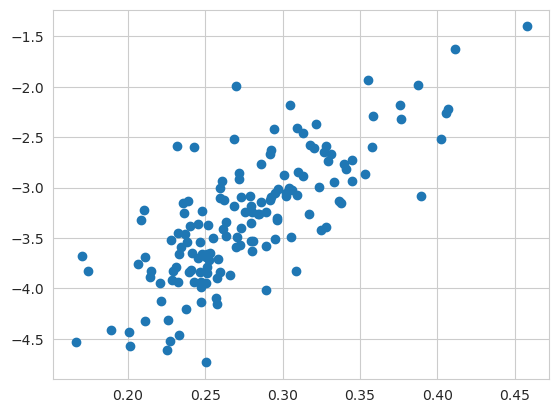

In [213]:
plt.scatter(y =np.log(data_heduc.share_ht), x = data_heduc.H_pct)

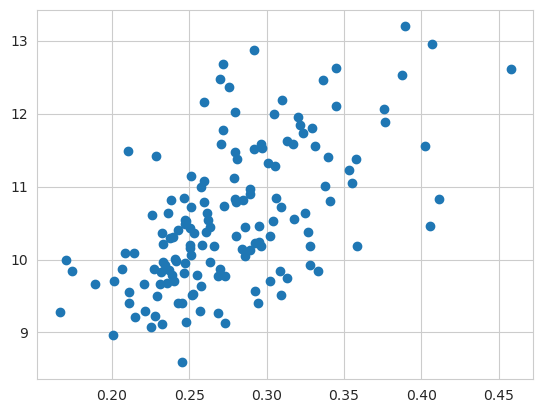

In [227]:
data_heduc
plt.scatter(y = np.log(data_heduc.IFLOW) , x = data_heduc.H_pct)

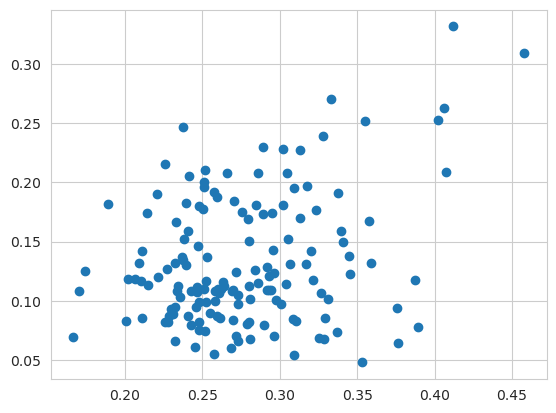

In [221]:
plt.scatter(y = data_heduc.OFLOW / data_heduc.emp, x = data_heduc.H_pct)

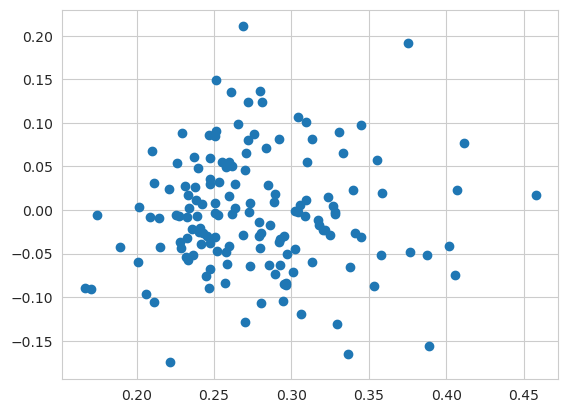

In [224]:
plt.scatter(y = np.log(data_heduc.IFLOW / data_heduc.OFLOW), x = data_heduc.H_pct)

# Some Plots

In [23]:
# Tag HT and Non-HT MSA based on the rank of share of HT jobs
threshold = 0.95
msa_dist_sector_dsimj2jod_sex1_age_lower_07["HT_orig_fixed"] = msa_dist_sector_dsimj2jod_sex1_age_lower_07.share_ht_rank_orig >= threshold
msa_dist_sector_dsimj2jod_sex1_age_lower_07["HT_dest_fixed"] = msa_dist_sector_dsimj2jod_sex1_age_lower_07.share_ht_rank_dest >= threshold
msa_dist_sector_dsimj2jod_sex1_educ["HT_orig_fixed"] = msa_dist_sector_dsimj2jod_sex1_educ.share_ht_rank_orig >= threshold
msa_dist_sector_dsimj2jod_sex1_educ["HT_dest_fixed"] = msa_dist_sector_dsimj2jod_sex1_educ.share_ht_rank_dest >= threshold

msa_dist_sector_dsimj2jod_sex1_age_lower_07["HT_orig_variable"] = msa_dist_sector_dsimj2jod_sex1_age_lower_07.share_ht_orig_variate >= threshold
msa_dist_sector_dsimj2jod_sex1_age_lower_07["HT_dest_variable"] = msa_dist_sector_dsimj2jod_sex1_age_lower_07.share_ht_dest_variate >= threshold
msa_dist_sector_dsimj2jod_sex1_educ["HT_orig_variable"] = msa_dist_sector_dsimj2jod_sex1_educ.share_ht_orig_variate >= threshold
msa_dist_sector_dsimj2jod_sex1_educ["HT_dest_variable"] = msa_dist_sector_dsimj2jod_sex1_educ.share_ht_dest_variate >= threshold

# Aggregate migration flows by HT and Non-HT
agg_no_educ = msa_dist_sector_dsimj2jod_sex1_age_lower_07.groupby(["year", "HT_orig_variable", "HT_dest_variable"])["OFLOW"].sum().reset_index()
agg_educ = msa_dist_sector_dsimj2jod_sex1_educ.groupby(["year", "education", "HT_orig_variable", "HT_dest_variable"])["OFLOW"].sum().reset_index()

In [24]:
agg_educ

year education  HT_orig_variable  HT_dest_variable      OFLOW
0    2000         H             False             False   267390.0
1    2000         H             False              True    33343.0
2    2000         H              True             False    27400.0
3    2000         H              True              True      989.0
4    2000         L             False             False   709041.0
..    ...       ...               ...               ...        ...
163  2020         H              True              True    21933.0
164  2020         L             False             False  1160496.0
165  2020         L             False              True   133948.0
166  2020         L              True             False   139092.0
167  2020         L              True              True    32064.0

[168 rows x 5 columns]

# Network Analysis

In [25]:
import networkx as nx

# Create a graph for each year

# Create a new empty directed graph
G_2002 = nx.DiGraph()
# Add the edges with weights to the graph
for _, row in  msa_dist_sector_dsimj2jod_sex1_age_lower_07[msa_dist_sector_dsimj2jod_sex1_age_lower_07.year == 2012].iterrows():
    source = row['msa_orig']
    target = row['msa_dest']
    weight = row['OFLOW']
    G_2002.add_edge(source, target, weight=weight)

in_deg = dict(G_2002.in_degree(weight="OFLOW"))
out_deg =dict( G_2002.out_degree(weight="OFLOW"))

# convert the two dictionaries to a pandas DataFrame
df = pd.DataFrame({'msa': list(in_deg.keys()), 'in_degree': list(in_deg.values()), 'out_degree': list(out_deg.values())})

# Add names of MSAs
df = pd.merge(df, msa_pop[["msa", "state", "name"]], left_on="msa", right_on="msa", how="inner")
# Add size of labor market
df = pd.merge(df, data_bds_msa[data_bds_msa.year == 2002][["msa", "emp"]], 
                left_on="msa", right_on="msa", how="inner")


# Add share of HT jobs
df = pd.merge(df, data_bds_ht_msa[data_bds_ht_msa.year == 2002][["msa", "share_ht"]],
                left_on="msa", right_on="msa", how="inner")

df.sort_values(by="in_degree", ascending=False).head(20)

msa  in_degree  out_degree         state  \
0   10420        149         148            OH   
70  36540        149         149         NE-IA   
83  40060        149         149            VA   
80  39580        149         149            NC   
79  39340        149         149            UT   
77  38900        149         149         OR-WA   
76  38300        149         149            PA   
75  37980        149         149   PA-NJ-DE-MD   
73  37860        149         149            FL   
72  37100        149         149            CA   
71  36740        149         149            FL   
67  36260        149         147            UT   
86  40380        149         149            NY   
65  35620        149         149      NY-NJ-PA   
64  35380        149         149            LA   
63  34980        149         149            TN   
61  33460        149         149         MN-WI   
60  33340        149         149            WI   
59  33100        149         149            FL   
58  31540        149         148            WI   

                                          name        emp  share_ht  
0                                        Akron   292655.0  0.034903  
70                        Omaha-Council Bluffs   380696.0  0.031516  
83                                    Richmond   496576.0  0.022551  
80                                Raleigh-Cary   382595.0  0.079246  
79                                  Provo-Orem   150523.0  0.063683  
77                Portland-Vancouver-Hillsboro   841942.0  0.074903  
76                                  Pittsburgh  1044407.0  0.045019  
75              Philadelphia-Camden-Wilmington  2480913.0  0.055658  
73                  Pensacola-Ferry Pass-Brent   127442.0  0.020435  
72                Oxnard-Thousand Oaks-Ventura   258067.0  0.061666  
71                   Orlando-Kissimmee-Sanford   812280.0  0.048760  
67                            Ogden-Clearfield   142503.0  0.055115  
86                                   Rochester   437291.0  0.048101  
65    New York-Northern New Jersey-Long Island  7631636.0  0.044632  
64                 New Orleans-Metairie-Kenner   522661.0  0.025149  
63  Nashville-Davidson--Murfreesboro--Franklin   685546.0  0.031587  
61            Minneapolis-St. Paul-Bloomington  1615140.0  0.059156  
60               Milwaukee-Waukesha-West Allis   758027.0  0.036710  
59         Miami-Fort Lauderdale-Pompano Beach  2012581.0  0.027484  
58                                     Madison   267854.0  0.050987

In [26]:
nx.is_weighted(G_2002)

True

In [27]:
aut, hub = nx.hits(G_2002)

# convert the two dictionaries to a pandas DataFrame
df = pd.DataFrame({'msa': list(in_deg.keys()), 'aut': list(aut.values()), 'hub': list(hub.values())})

# Add names of MSAs
df = pd.merge(df, msa_pop[["msa", "state", "name"]], left_on="msa", right_on="msa", how="inner")
# Add size of labor market
df = pd.merge(df, data_bds_msa[data_bds_msa.year == 2002][["msa", "emp"]], 
                left_on="msa", right_on="msa", how="inner")

# Add share of HT jobs
df = pd.merge(df, data_bds_ht_msa[data_bds_ht_msa.year == 2002][["msa", "share_ht"]],
                left_on="msa", right_on="msa", how="inner")

df.sort_values(by="hub", ascending=False).head(20)

/software/anaconda/lib/python3.9/site-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


msa       aut       hub         state  \
46   26420  0.106703  0.123845            TX   
27   19100  0.114110  0.112553            TX   
8    12420  0.068988  0.075022            TX   
91   41700  0.063728  0.058940            TX   
65   35620  0.030657  0.029914      NY-NJ-PA   
135  47900  0.026155  0.024919   DC-VA-MD-WV   
75   37980  0.021087  0.021868   PA-NJ-DE-MD   
12   13140  0.025501  0.021740            TX   
10   12580  0.018367  0.020360            MD   
26   18580  0.018258  0.019009            TX   
93   41860  0.013794  0.016093            CA   
21   16980  0.016927  0.015546      IL-IN-WI   
59   33100  0.015020  0.015335            FL   
71   36740  0.013188  0.013317            FL   
106  45300  0.012578  0.013152            FL   
94   41940  0.011163  0.012175            CA   
6    12060  0.012817  0.011770            GA   
34   21340  0.013113  0.011145            TX   
133  38060  0.009919  0.009858            AZ   
68   36420  0.008344  0.009643            OK   

                                         name        emp  share_ht  
46                 Houston-Sugar Land-Baytown  1992394.0  0.055783  
27                Dallas-Fort Worth-Arlington  2490575.0  0.076044  
8                Austin-Round Rock-San Marcos   552200.0  0.133050  
91                  San Antonio-New Braunfels   640299.0  0.044638  
65   New York-Northern New Jersey-Long Island  7631636.0  0.044632  
135           Washington-Arlington-Alexandria  2218508.0  0.123069  
75             Philadelphia-Camden-Wilmington  2480913.0  0.055658  
12                       Beaumont-Port Arthur   126684.0  0.018021  
10                           Baltimore-Towson  1050992.0  0.061289  
26                             Corpus Christi   132405.0  0.017288  
93              San Francisco-Oakland-Fremont  1876053.0  0.091734  
21                  Chicago-Joliet-Naperville  4016935.0  0.042626  
59        Miami-Fort Lauderdale-Pompano Beach  2012581.0  0.027484  
71                  Orlando-Kissimmee-Sanford   812280.0  0.048760  
106           Tampa-St. Petersburg-Clearwater  1113253.0  0.036031  
94             San Jose-Sunnyvale-Santa Clara   897209.0  0.262330  
6              Atlanta-Sandy Springs-Marietta  2073552.0  0.051750  
34                                    El Paso   195845.0  0.020772  
133                     Phoenix-Mesa-Glendale  1400286.0  0.063779  
68                              Oklahoma City   437700.0  0.041704

In [28]:
# Repeat for msa_dist_sector_dsimj2jod_sex1_educ creating a graph for each education level

# Create a new empty directed graphs
G_2002_H = nx.DiGraph()
G_2002_L = nx.DiGraph()

# Add the edges with weights to each graph
# College
for _, row in  msa_dist_sector_dsimj2jod_sex1_educ[
    (msa_dist_sector_dsimj2jod_sex1_educ.year == 2008 )&
    (msa_dist_sector_dsimj2jod_sex1_educ.education == "H" )
    ].iterrows():
    source = row['msa_orig']
    target = row['msa_dest']
    weight = row['OFLOW_share']
    G_2002_H.add_edge(source, target, weight=weight) 
# No college
for _, row in  msa_dist_sector_dsimj2jod_sex1_educ[
    (msa_dist_sector_dsimj2jod_sex1_educ.year == 2008 )&
    (msa_dist_sector_dsimj2jod_sex1_educ.education == "L" )
    ].iterrows():
    source = row['msa_orig']
    target = row['msa_dest']
    weight = row['OFLOW_share']
    G_2002_L.add_edge(source, target, weight=weight) 


aut_L, hub_L = nx.hits(G_2002_L)
aut_H, hub_H = nx.hits(G_2002_H)

# convert the two dictionaries to a pandas DataFrame
df = pd.merge(
    pd.DataFrame(
        {'msa': list(aut_L.keys()), 'aut_L': list(aut_L.values()), 'hub_L': list(hub_L.values())}
    ),
    pd.DataFrame(
        {'msa': list(aut_H.keys()), 'aut_H': list(aut_L.values()), 'hub_H': list(hub_L.values())}
    ),
    on="msa"
)


# Add names of MSAs
df = pd.merge(df, msa_pop[["msa", "state", "name"]], left_on="msa", right_on="msa", how="inner")
# # Add size of labor market
# df = pd.merge(df, data_bds_msa[data_bds_msa.year == 2002][["msa", "emp"]], 
#                 left_on="msa", right_on="msa", how="inner")

# Add emp_ht_share_total
df = pd.merge(df, data_bds_ht_msa[data_bds_ht_msa.year == 2002][["msa", "emp_ht_share_total"]],
                left_on="msa", right_on="msa", how="inner")

df.sort_values(by="hub_H", ascending=False).head(20)

/software/anaconda/lib/python3.9/site-packages/networkx/algorithms/link_analysis/hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


msa     aut_L     hub_L     aut_H     hub_H         state  \
51   28140  0.006267  0.012522  0.012061  0.062591         MO-KS   
29   19100  0.015590  0.048910  0.015590  0.048910            TX   
23   16980  0.006032  0.034941  0.006032  0.034941      IL-IN-WI   
31   19740  0.004931  0.026798  0.004931  0.026798            CO   
70   36420  0.007818  0.007680  0.006466  0.025338            OK   
114  48620  0.007346  0.002605  0.006569  0.019819            KS   
101  42660  0.005567  0.016738  0.004586  0.019610            WA   
102  43340  0.009969  0.003216  0.005181  0.019228            LA   
99   42220  0.006758  0.001727  0.017776  0.018749            CA   
80   38940  0.007974  0.001740  0.006817  0.017136            FL   
6    12060  0.006891  0.017056  0.006891  0.017056            GA   
59   31180  0.014748  0.004378  0.006039  0.016807            TX   
107  45060  0.005744  0.005142  0.005567  0.016738            NY   
21   16740  0.004186  0.016444  0.004186  0.016444         NC-SC   
77   37980  0.006817  0.017136  0.007259  0.016331   PA-NJ-DE-MD   
8    12420  0.018813  0.016128  0.018813  0.016128            TX   
33   19820  0.005020  0.014740  0.005020  0.014740            MI   
139  36260  0.004859  0.002983  0.008497  0.013904            UT   
83   39740  0.005399  0.002776  0.005248  0.012901            PA   
55   29460  0.007614  0.004230  0.006267  0.012522            FL   

                               name  emp_ht_share_total  
51                      Kansas City            0.008504  
29      Dallas-Fort Worth-Arlington            0.037337  
23        Chicago-Joliet-Naperville            0.033756  
31         Denver-Aurora-Broomfield            0.014547  
70                    Oklahoma City            0.003599  
114                         Wichita            0.007680  
101         Seattle-Tacoma-Bellevue            0.028798  
102         Shreveport-Bossier City            0.000311  
99              Santa Rosa-Petaluma            0.002190  
80                   Port St. Lucie            0.000594  
6    Atlanta-Sandy Springs-Marietta            0.021153  
59                          Lubbock            0.000266  
107                        Syracuse            0.001948  
21     Charlotte-Gastonia-Rock Hill            0.005469  
77   Philadelphia-Camden-Wilmington            0.027229  
8      Austin-Round Rock-San Marcos            0.014387  
33           Detroit-Warren-Livonia            0.025954  
139                Ogden-Clearfield            0.001548  
83                          Reading            0.000994  
55            Lakeland-Winter Haven            0.000485

In [29]:
df.sort_values(by="aut_H", ascending=False).head(20)

msa     aut_L     hub_L     aut_H     hub_H      state  \
12   13140  0.023664  0.004775  0.023664  0.004775         TX   
28   18580  0.018871  0.006787  0.018871  0.006787         TX   
8    12420  0.018813  0.016128  0.018813  0.016128         TX   
99   42220  0.006758  0.001727  0.017776  0.018749         CA   
29   19100  0.015590  0.048910  0.015590  0.048910         TX   
38   22180  0.005019  0.002016  0.015161  0.005355         NC   
124  17140  0.004369  0.007516  0.015054  0.003722   OH-KY-IN   
64   34940  0.006403  0.002467  0.014748  0.004378         FL   
123  13820  0.004975  0.005932  0.014425  0.003948         AL   
125  17980  0.006939  0.001514  0.014034  0.001554      GA-AL   
58   29820  0.006833  0.008716  0.012829  0.005761         NV   
79   38900  0.005248  0.012901  0.012525  0.001843      OR-WA   
51   28140  0.006267  0.012522  0.012061  0.062591      MO-KS   
25   17820  0.010666  0.003772  0.010666  0.003772         CO   
108  45300  0.006569  0.019819  0.009969  0.003216         FL   
14   14500  0.009798  0.003830  0.009798  0.003830         CO   
95   41740  0.006585  0.007430  0.009269  0.011568         CA   
11   12940  0.009014  0.012218  0.009014  0.012218         LA   
10   12580  0.008931  0.006073  0.008931  0.006073         MD   
2    10740  0.008815  0.003199  0.008815  0.003199         NM   

                                name  emp_ht_share_total  
12              Beaumont-Port Arthur            0.000450  
28                    Corpus Christi            0.000451  
8       Austin-Round Rock-San Marcos            0.014387  
99               Santa Rosa-Petaluma            0.002190  
29       Dallas-Fort Worth-Arlington            0.037337  
38                      Fayetteville            0.000259  
124            Cincinnati-Middletown            0.007990  
64               Naples-Marco Island            0.000456  
123                Birmingham-Hoover            0.002643  
125                         Columbus            0.000690  
58                Las Vegas-Paradise            0.003112  
79      Portland-Vancouver-Hillsboro            0.012431  
51                       Kansas City            0.008504  
25                  Colorado Springs            0.004390  
108  Tampa-St. Petersburg-Clearwater            0.007907  
14                           Boulder            0.006337  
95     San Diego-Carlsbad-San Marcos            0.019913  
11                       Baton Rouge            0.001623  
10                  Baltimore-Towson            0.012698  
2                        Albuquerque            0.003703

Text(0, 0.5, 'Authority score (high education)')

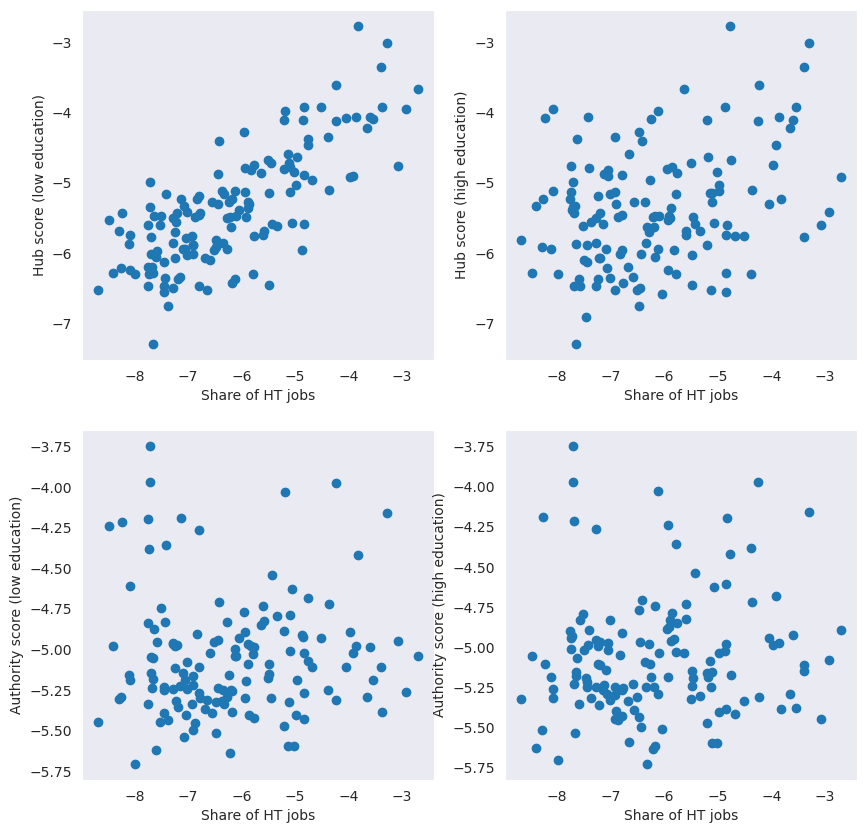

In [30]:
# Scatter of each measure of importance against the share of HT jobs
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].scatter(np.log(df.emp_ht_share_total), np.log(df.hub_L))
ax[0,1].scatter(np.log(df.emp_ht_share_total), np.log(df.hub_H))
ax[1,0].scatter(np.log(df.emp_ht_share_total), np.log(df.aut_L))
ax[1,1].scatter(np.log(df.emp_ht_share_total), np.log(df.aut_H))
# Label the axes
ax[0,0].set_xlabel("Share of HT jobs")
ax[0,1].set_xlabel("Share of HT jobs")
ax[1,0].set_xlabel("Share of HT jobs")
ax[1,1].set_xlabel("Share of HT jobs")
ax[0,0].set_ylabel("Hub score (low education)")
ax[0,1].set_ylabel("Hub score (high education)")
ax[1,0].set_ylabel("Authority score (low education)")
ax[1,1].set_ylabel("Authority score (high education)")




In [31]:
ax

array([[<AxesSubplot: xlabel='Share of HT jobs', ylabel='Hub score (low education)'>,
        <AxesSubplot: xlabel='Share of HT jobs', ylabel='Hub score (high education)'>],
       [<AxesSubplot: xlabel='Share of HT jobs', ylabel='Authority score (low education)'>,
        <AxesSubplot: xlabel='Share of HT jobs', ylabel='Authority score (high education)'>]],
      dtype=object)

/tmp/ipykernel_3502292/1513035960.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["OFLOW"] = (df["OFLOW"] - np.mean(df["OFLOW"]) ) / np.std(df["OFLOW"])


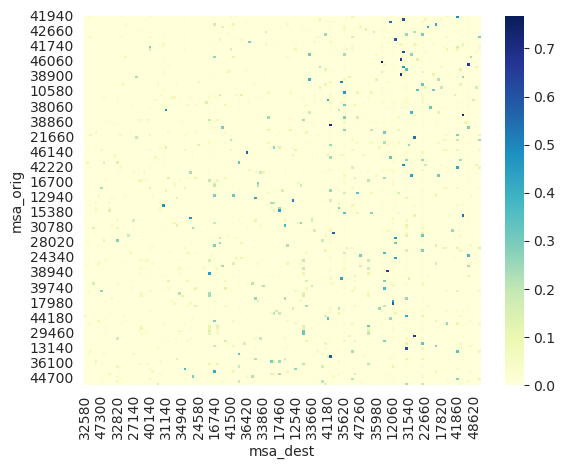

In [32]:
# Create a dataset
df =  msa_dist_sector_dsimj2jod_sex1_educ[
    (msa_dist_sector_dsimj2jod_sex1_educ.year == 2008 )&
    (msa_dist_sector_dsimj2jod_sex1_educ.education == "L" )]
# Get list of MSAs and their share_ht
msa_ht = df[["msa_orig", "share_ht_orig"]].drop_duplicates()

df["OFLOW"] = (df["OFLOW"] - np.mean(df["OFLOW"]) ) / np.std(df["OFLOW"])

df = df[['msa_orig', 'msa_dest', 'OFLOW_share']].pivot(index='msa_orig', columns='msa_dest', values='OFLOW_share').fillna(0)

msa_sorted = msa_ht.sort_values(by="share_ht_orig", ascending=True).msa_orig.tolist()
msa_sorted_inv = msa_ht.sort_values(by="share_ht_orig", ascending=False).msa_orig.tolist()

# # Sort the dataframe
df = df.reindex(index=msa_sorted_inv, columns=msa_sorted)


# # # plot using a color palette
sns.heatmap(df, cmap="YlGnBu")
plt.show()

In [33]:
df

msa_dest     32580     28700     44700     22900     49660     25860  \
msa_orig                                                               
41940     0.000427  0.000000  0.033173  0.000122  0.000183  0.000366   
14500     0.000226  0.000677  0.000677  0.000000  0.000451  0.000677   
48620     0.000949  0.000000  0.002214  0.001898  0.000000  0.000316   
20500     0.000000  0.000526  0.000351  0.000351  0.000877  0.011049   
47900     0.000260  0.002246  0.000521  0.000391  0.000325  0.000358   
...            ...       ...       ...       ...       ...       ...   
49660     0.001001  0.000000  0.000000  0.000500  0.000000  0.001001   
22900     0.003483  0.000000  0.000000  0.000000  0.002438  0.000348   
44700     0.000370  0.000185  0.000000  0.000185  0.000556  0.000185   
28700     0.000000  0.000000  0.000000  0.004739  0.004739  0.005332   
32580     0.000000  0.000263  0.000789  0.001315  0.000000  0.001052   

msa_dest     47300     16860     36100     15940  ...     11460     41860  \
msa_orig                                          ...                       
41940     0.008476  0.000610  0.000061  0.000000  ...  0.000488  0.485883   
14500     0.000902  0.000902  0.000226  0.000000  ...  0.000677  0.002933   
48620     0.001898  0.002847  0.000949  0.000316  ...  0.000633  0.004429   
20500     0.000000  0.001754  0.000351  0.000175  ...  0.000877  0.002105   
47900     0.000228  0.000781  0.000456  0.000293  ...  0.000521  0.006379   
...            ...       ...       ...       ...  ...       ...       ...   
49660     0.000000  0.003002  0.000751  0.078559  ...  0.001251  0.000500   
22900     0.000000  0.007315  0.000348  0.002090  ...  0.000697  0.003135   
44700     0.014074  0.001481  0.000185  0.000185  ...  0.000185  0.273889   
28700     0.000000  0.031398  0.001777  0.000000  ...  0.001777  0.001777   
32580     0.002367  0.002367  0.000000  0.000000  ...  0.000263  0.001315   

msa_dest     12420     42660     31700     47900     20500     48620  \
msa_orig                                                               
41940     0.003842  0.012013  0.000061  0.003415  0.000427  0.000488   
14500     0.002707  0.005414  0.001805  0.003835  0.002030  0.000677   
48620     0.005378  0.012654  0.000633  0.005062  0.000633  0.000000   
20500     0.002455  0.000702  0.000526  0.024377  0.000000  0.000877   
47900     0.003645  0.005826  0.000260  0.000000  0.004329  0.000358   
...            ...       ...       ...       ...       ...       ...   
49660     0.001751  0.002502  0.000500  0.003002  0.002002  0.000250   
22900     0.001742  0.001393  0.000697  0.000697  0.000000  0.004180   
44700     0.001481  0.004815  0.000185  0.002593  0.000370  0.000741   
28700     0.003555  0.002370  0.001185  0.043839  0.003555  0.000592   
32580     0.062056  0.000789  0.000000  0.002104  0.000526  0.001052   

msa_dest     14500     41940  
msa_orig                      
41940     0.001159  0.000000  
14500     0.000000  0.003158  
48620     0.001265  0.002847  
20500     0.000877  0.002105  
47900     0.000423  0.002539  
...            ...       ...  
49660     0.001001  0.001001  
22900     0.000000  0.001393  
44700     0.000370  0.093704  
28700     0.000000  0.001777  
32580     0.000263  0.001841  

[147 rows x 147 columns]

In [34]:
# Sort the dataframe by the share of HT jobs
df = df.reindex(msa_ht_sorted, axis=0)
# Sort columns by the share of HT jobs
df = df.reindex(msa_ht_sorted, axis=1)
df

NameError: name 'msa_ht_sorted' is not defined

In [ ]:
df.columns

Int64Index([10420, 10580, 10740, 10900, 11100, 11460, 11700, 12060, 12260,
            12420,
            ...
            46140, 46540, 46700, 47260, 47300, 47900, 48620, 49180, 49620,
            49660],
           dtype='int64', name='msa_dest', length=147)